# Fish

Based on the idea of aligned showers, this model is quasi continuous.

Before fitting the model, the dataset is shifted so that the mean of the showers is in the same location along the shower axis.
This goes a long way towards decoupling the distributions.

Then 8 fits are calculated;

1. A polynomial (order 3) through the shift mean and standard devation against incident energy. For a given incident energy, values will be drawn from a gumbel distribution for each event.
2. A gaussian fit between the mean number of hits against the distance along the shower axis. The height of the gauissian varies in a linear relation with the incident energy.
3. A polynomial (order 12) if fit between the coefficient of variation of the number of hits and the distance along the shower axis. The coefficient of variation is the standard devation divided by the mean. This is not varied with incident energy. With this fit, and the previous 2, for any given incident energy and displacement along the shower axis, a mean and standard devation for the number of hits in the layer can be determined. From this, a Weibull distribution is constructed, and the actual number of hits in an event is drawn from the Weibull.
4. At each incident energy, a gumbel distribution is fit between the mean point energy and the distance along the shower axis. Each gumbel distribution had itself 4 parameters; mu, beta, height and lift. To capture the variation with incident energy, the values of mu and beta are fit to a quadratic against incident eenrgy and the values of height and lift get a linear fit against incident energy. Collectively, this allows a mean point energy at each incident energy and distance along the shower axis to be calculated.
5. As with the coefficient of variation in the number of hits, the coefficienti of variation of the mean energy is fit only against distance from the shower center, and it is likewise fit with a 12th order polynomial.
6. A linear fit is constructed between the standard devation of the energies of hits in a layer and the incident energy. This will be used to rescale the standard devations at each incident energy before the next fit is carried out.
7. A gumbel is fit to the standard devation of the rescaled energies of hits in a layer and the distance along the shower axis from the shower center. This, in combination with the previous fit, allows the standard devation of energies within a layer to be found for any given incident energy and distance along the shower axis. The energies of that layer are then drawn from a log normal distribution using this standard devation, and the mean energy drawn for that layer.
8. Finally, we need a radial distribution. This varies only with distance along the shower axis, not incident energy. It's the least stable of all the fits. The function chosen is a tailed exponential. This tailed exponential has 3 parameters, the core width, the tail width and the probability of being in the core distribution. Once these parameters are fit for each distance, a quadratic is fit through each of them against the distance from the center of the shower.



In [1]:
redo_model = True
import os
import numpy as np
from matplotlib import pyplot as plt
from pointcloud.config_varients.wish import Configs
from pointcloud.models import fish
import torch
config = Configs()

fish_dir = os.path.join(config.logdir, "fish")
os.makedirs(fish_dir, exist_ok=True)
fish_path = os.path.join(fish_dir, "fish.npz")
acc_path = os.path.join(config.logdir, "dataset_accumulators/p22_th90_ph90_en10-1/p22_th90_ph90_en10-100_seedAll_alignMean.h5")

if os.path.exists(fish_path) and not redo_model:
    model = fish.Fish.load(fish_path)
else:
    print("Creating model")
    model = fish.load_fish_from_accumulator(accumulator=acc_path, config=config)
    model.save(fish_path)

Creating model
Generating parameters
Fitting shift
Fitting mean nHits 
Fitting mean nHits
Fitting cv nHits
Fitting mean energy
..........

/home/dayhallh/training/point-cloud-diffusion/scripts/plotting/pointcloud/models/fish_parametrise.py:138: RuntimeWarning: invalid value encountered in divide
  n_hits_mean = n_hits_per_bin / events_per_bin
/home/dayhallh/training/point-cloud-diffusion/scripts/plotting/pointcloud/utils/maths.py:94: UserWarning: Warning: Numerical issues with Gumbel function.
  warnings.warn("Warning: Numerical issues with Gumbel function.")


.....Fitting cv energy
Fitting stdEWithin vs incident
Fitting radial probs
.

/home/dayhallh/training/point-cloud-diffusion/scripts/plotting/pointcloud/models/fish_parametrise.py:529: RuntimeWarning: invalid value encountered in sqrt
  std_e_within = np.sqrt(pnt_mean_E_sq - mean_pnt_E_sq)


.................................................

The model is loaded, let's just plot a couple of events to see it in comparison to the data.

In [2]:
from pointcloud.data.read_write import read_raw_regaxes
energies, events = read_raw_regaxes(config, total_size=100)


Selecting evenly spaced events


In [3]:
def plot_event(event_n, energy_in, use_event, energy_scale=100., x_scale=1, ax=None):
    energy = use_event[:, 3]
    mask = energy>0
    n_points = sum(mask)
    energy = energy[mask] * energy_scale
    xs = use_event[mask, 0] * x_scale
    ys = use_event[mask, 1] 
    zs = use_event[mask, 2] * x_scale
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    if len(energy):
        print(f"{event_n}, {np.min(energy)}, {np.mean(energy)}, {np.max(energy)}")
    else:
        print(f"event {event_n} empty")
    ax.scatter(xs, ys, zs, c=energy, s=energy, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-150, 150)
    ax.set_zlim(-150, 150)
    # write a title
    observed_energy = energy.sum()
    ax.set_title(f'Evt: {event_n}, $n_{{pts}}$: {n_points}, $E_{{in}}$: {energy_in:.2f}, $E_{{vis}}$: {observed_energy:.2f}')
    
def plot_model(energy_in, model, ax=None):
    conditioning = torch.atleast_1d(torch.tensor(energy_in))[:, None]
    event = model.sample(conditioning, 6000)
    xs, ys, zs, es = event[0].T
    event = np.zeros((len(xs), 4))
    event[:, 0] = xs
    event[:, 1] = ys
    event[:, 2] = zs
    event[:, 3] = es
    plot_event("Modeled", energy_in, event, energy_scale=0.1, x_scale=150, ax=ax)

0, 1.1328666005283594e-08, 0.036075081676244736, 0.9880419969558716
100% - Done
Modeled, 0.0016743844375014306, 0.036586098568735737, 0.533510684967041
1, 2.6977702418662375e-06, 0.03362070769071579, 0.7038986086845398
100% - Done
Modeled, 0.00463925413787365, 0.0352309118696377, 0.16898871660232545
2, 1.1904921493055554e-08, 0.04292616620659828, 1.9784811735153198
100% - Done
Modeled, 0.0013837705366313458, 0.0376614114948195, 1.6229299545288087
3, 8.067302405834198e-05, 0.03417351096868515, 0.6074639558792114
100% - Done
Modeled, 0.0038644287735223773, 0.03463634654796834, 0.2269866704940796
4, 2.845990776378926e-09, 0.040807824581861496, 1.9453463554382324
100% - Done
Modeled, 0.0017181597650051117, 0.03863461126606946, 0.5170040130615234


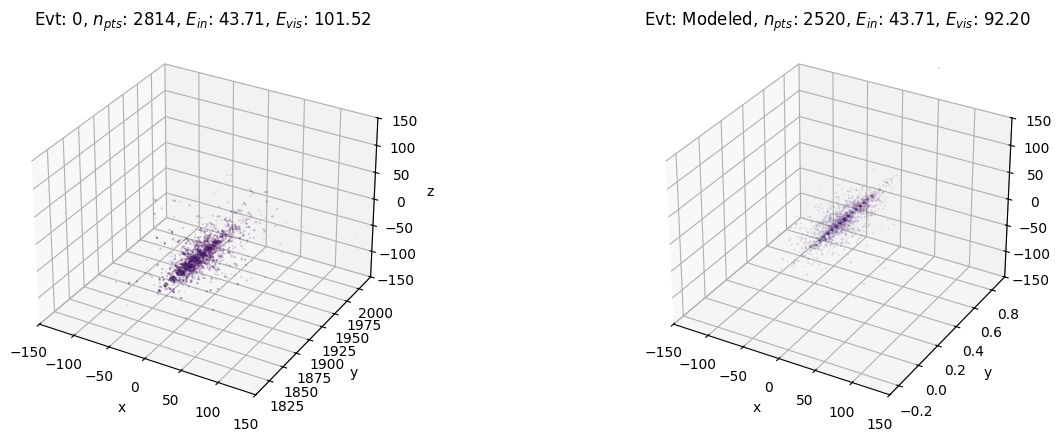

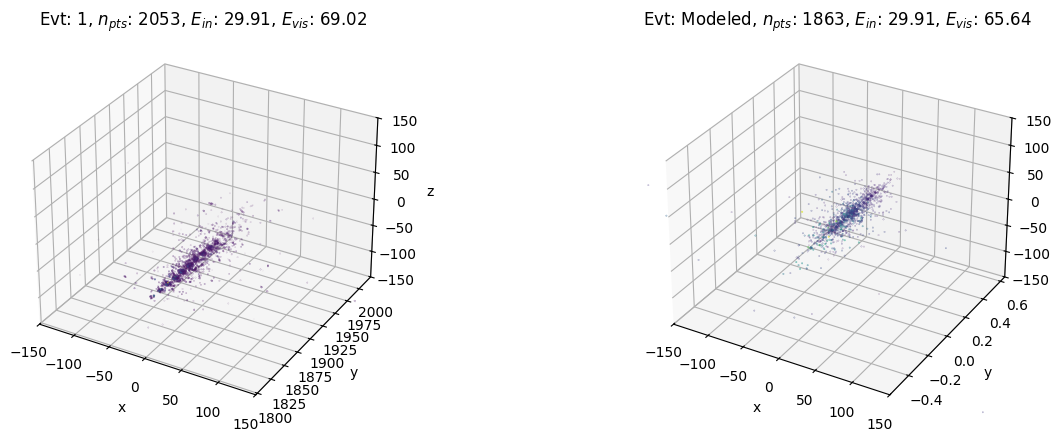

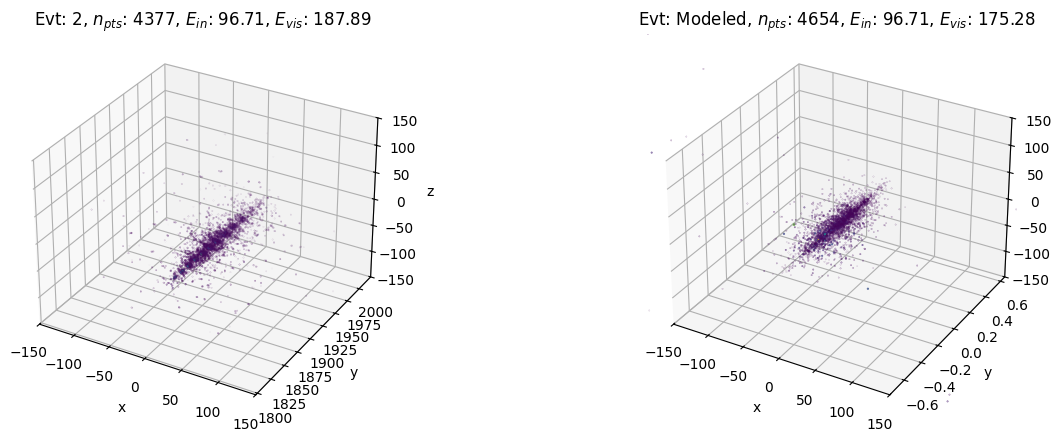

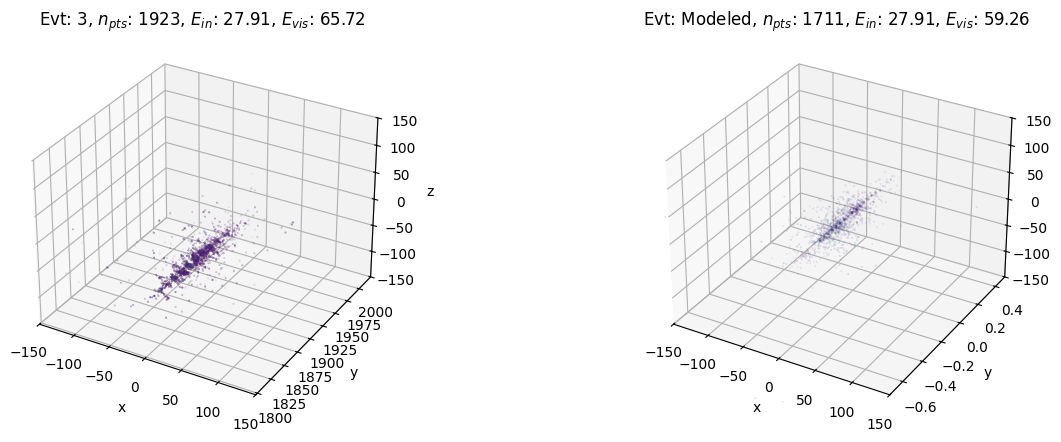

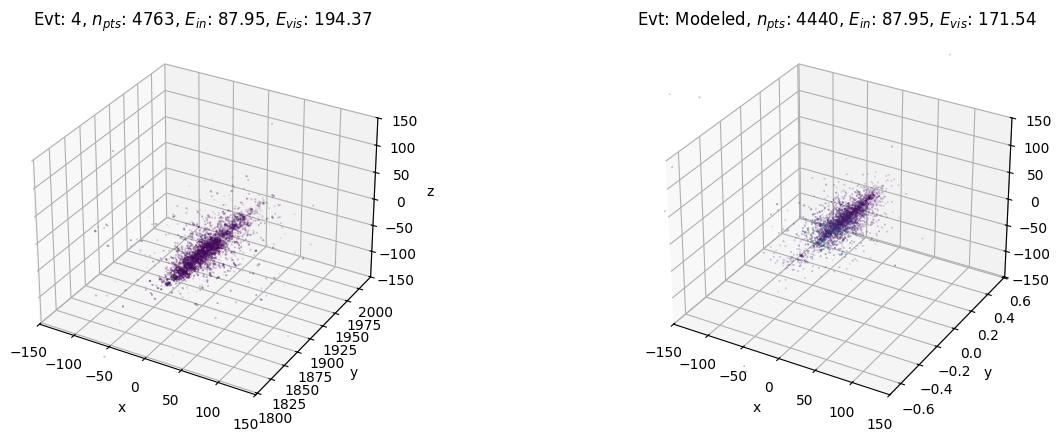

In [4]:
for i in range(5):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    plot_event(i, energies[i], events[i], ax=ax1)
    plot_model(energies[i], model, ax=ax2)

## Composite plots

By looking at the accumulator from which the fish model was build, each part of it is verified in turn.

1. The parametrised values are checked.
2. The output of `model.calc_stats` is checked.
3. The output of `model.sample_axial_components` is checked.


In [5]:
from pointcloud.models.fish_parametrise import Parametrisation, distance_bin_centers, incident_bin_centers
from pointcloud.utils.stats_accumulator import AlignedStatsAccumulator

acc = AlignedStatsAccumulator.load(acc_path)
distances = distance_bin_centers(acc)
assert distances.shape == model.distances.shape, f"{distances.shape} {model.distances.shape}"
incidents = incident_bin_centers(acc)
param = Parametrisation.load(fish_path)
stats = model.calc_stats(incidents, True, True)
n_samples = 100_000
stacked_incidents = np.repeat(incidents, (n_samples,))
components = model.sample_axial_components(model.calc_stats(stacked_incidents))

## The shift

First distribution to be visulised.

In [6]:
from pointcloud.utils.plotting import nice_hex

i = 2
acc_kws = dict(label="acc", lw=10, c=nice_hex[i][0], ls=':', alpha=1)
binned_kws = dict(label="binned", lw=9, c=nice_hex[i+2][0], ls=':', alpha=1)
found_kws = dict(label="found", lw=9, c=nice_hex[i+2][1], ls='--', alpha=1)
param_kws = dict(label="param", lw=8, c=nice_hex[i][1], ls='--', alpha=1)
stats_kws = dict(label="stats", lw=6, c=nice_hex[i][2], alpha=0.8)
sampled_kws = dict(label="sampled", lw=4, c=nice_hex[i][3], alpha=0.8)


Text(0, 0.5, 'standard devation shift')

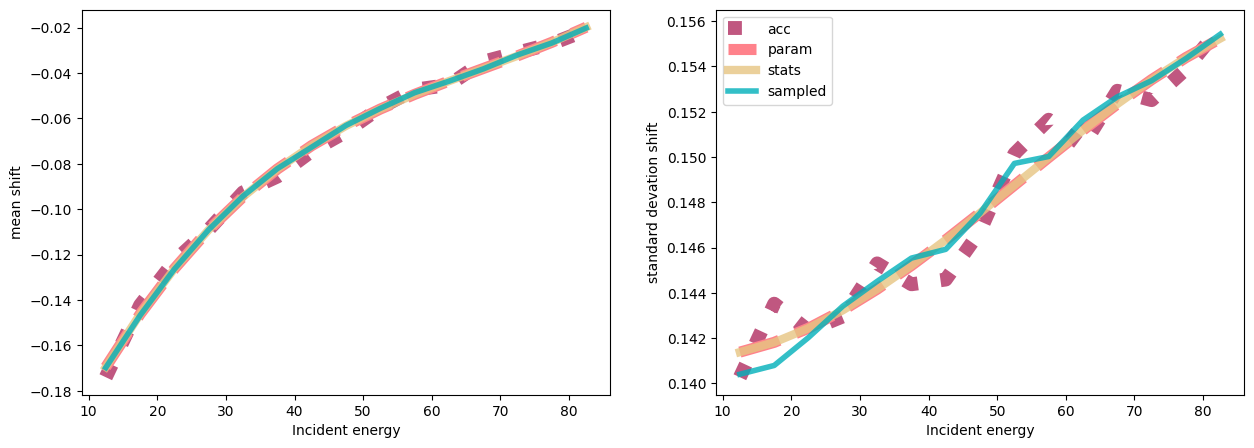

In [7]:

fig, (ax_m, ax_s) = plt.subplots(1, 2, figsize=(15, 5))

# accumulator
sum_over = 1
shift_bins = acc.layer_offset_bins
shift_centers = 0.5 * (shift_bins[1:] + shift_bins[:-1])
shift_hist = acc.layer_offset_hist[1:-1]
sum_per_incident = np.nansum(shift_hist, axis=sum_over)
mean_shifts_acc = np.nansum(shift_hist*shift_centers, axis=sum_over)/sum_per_incident
shift_hist_sq = acc.layer_offset_sq_hist[1:-1]
sum_per_incident = np.nansum(shift_hist_sq, axis=1)
mean_shifts_sq = np.nansum(shift_hist_sq*shift_centers, axis=sum_over)/sum_per_incident
std_shifts_acc = np.sqrt(mean_shifts_sq - mean_shifts_acc**2)

ax_m.plot(incidents, mean_shifts_acc, **acc_kws)
ax_s.plot(incidents, std_shifts_acc, **acc_kws)

# paramd
mean_shifts_param = np.polyval(param.shift_mean, incidents)
std_shifts_param = np.polyval(param.shift_std, incidents)
ax_m.plot(incidents, mean_shifts_param, **param_kws)
ax_s.plot(incidents, std_shifts_param, **param_kws)

# calc stats
import torch.distributions.gumbel
dist = torch.distributions.gumbel.Gumbel(stats["shift_gumbel_mu"], stats["shift_gumbel_beta"])
mean_shifts_stats = dist.mean
std_shifts_stats = dist.stddev

ax_m.plot(incidents, mean_shifts_stats, **stats_kws)
ax_s.plot(incidents, std_shifts_stats, **stats_kws)

# sampled_stats
shifts = components['shift'].numpy().reshape((-1, n_samples))
mean_shifts_sampled = np.mean(shifts, axis=1)
std_shifts_sampled = np.std(shifts, axis=1)


ax_m.plot(incidents, mean_shifts_sampled, **sampled_kws)
ax_s.plot(incidents, std_shifts_sampled, **sampled_kws)

ax_s.legend()
ax_m.set_xlabel("Incident energy")
ax_s.set_xlabel("Incident energy")
ax_m.set_ylabel("mean shift")
ax_s.set_ylabel("standard devation shift")




## Number of hits

This changes with both incident energy and distance from center, so we plot marginals of both.
Firstly we look at the mean number of hits per layer, then we consider the standard devation in the layer.


/tmp/ipykernel_22593/3932214972.py:6: RuntimeWarning: invalid value encountered in divide
  mean_hits_acc = np.nansum(hits_hist, axis=(2, 3))/n_events_acc
/tmp/ipykernel_22593/3932214972.py:8: RuntimeWarning: invalid value encountered in divide
  mean_hits_sq = hits_hist_sq/n_events_acc
/home/dayhallh/training/point-cloud-diffusion/scripts/plotting/pointcloud/models/fish_parametrise.py:138: RuntimeWarning: invalid value encountered in divide
  n_hits_mean = n_hits_per_bin / events_per_bin
/tmp/ipykernel_22593/3932214972.py:57: RuntimeWarning: invalid value encountered in divide
  acc_mean_hits = np.nansum(mean_hits_acc*bin_weights, axis=(sum_over))/np.nansum(bin_weights, axis=sum_over)
/tmp/ipykernel_22593/3932214972.py:58: RuntimeWarning: invalid value encountered in divide
  acc_std_hits = np.nansum(std_hits_acc*bin_weights, axis=(sum_over))/np.nansum(bin_weights, axis=sum_over)
/tmp/ipykernel_22593/3932214972.py:67: RuntimeWarning: invalid value encountered in divide
  mean_hits_bin

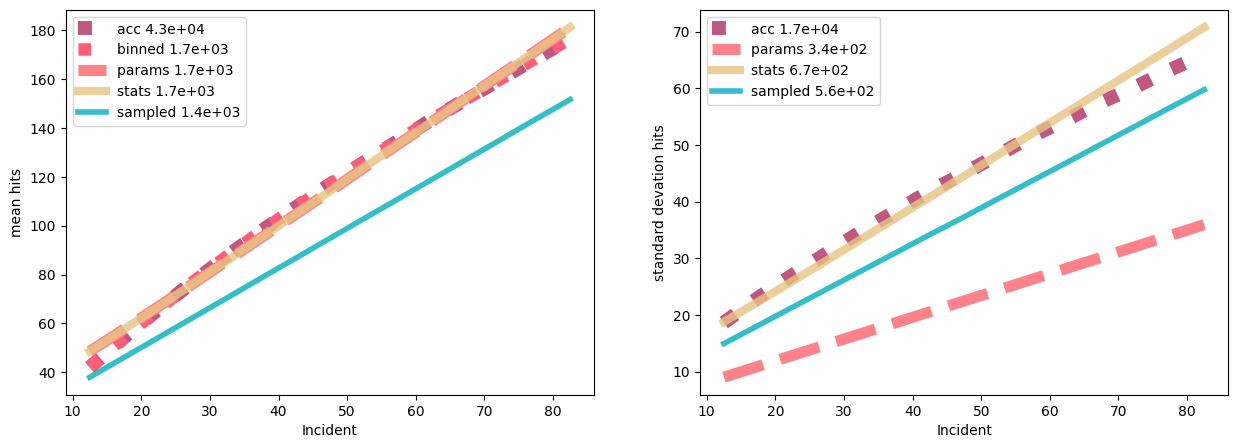

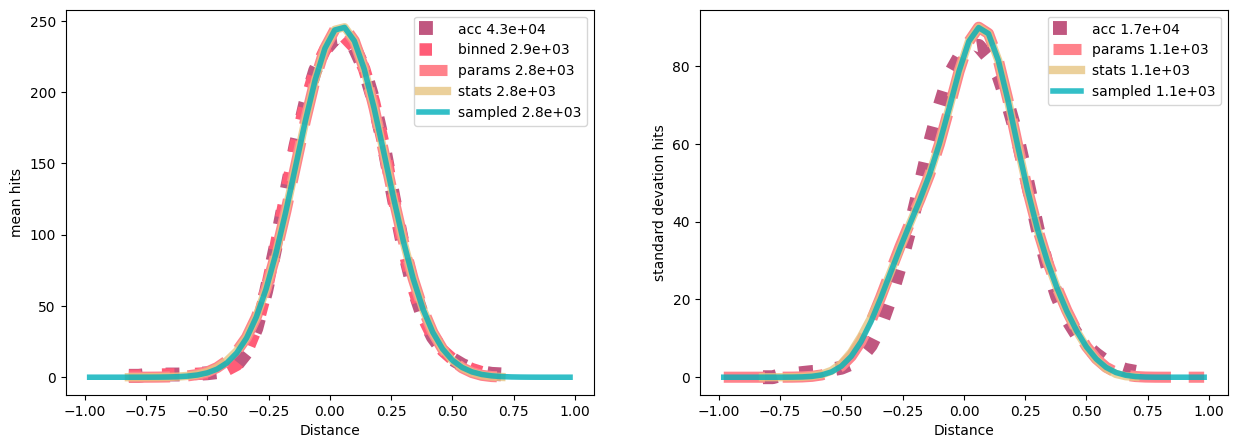

In [8]:
bin_weights = acc.total_events[1:-1]

#acc
n_events_acc = acc.total_events[1:-1]
hits_hist = acc.counts_hist[1:-1]
mean_hits_acc = np.nansum(hits_hist, axis=(2, 3))/n_events_acc
hits_hist_sq = acc.evt_counts_sq_hist[1:-1]
mean_hits_sq = hits_hist_sq/n_events_acc
std_hits_acc = np.sqrt(mean_hits_sq - mean_hits_acc**2)

# bins
from pointcloud.models.fish_parametrise import binned_mean_nHits
binned_mean_n_hits, self_weights = binned_mean_nHits(acc)
binned_weighted_hits = binned_mean_n_hits * bin_weights

# paramd bins
from pointcloud.utils.maths import gaussian
heights = np.polyval(param.nhm_vs_incident_height, incidents)[:, np.newaxis]
paramd_hits = gaussian(torch.tensor(distances), param.nhm_vs_dist_mean,
                        param.nhm_vs_dist_var, torch.tensor(heights))
paramd_weighted_hits = paramd_hits*bin_weights

cv_hits = np.polyval(param.cv_n_hits, distances)
paramd_std_hits = paramd_hits*cv_hits
paramd_weighted_std_hits = paramd_weighted_hits*cv_hits


# stats bins
from torch.distributions.weibull import Weibull
dist = Weibull(stats["n_hits_weibull_scale"], stats["n_hits_weibull_concen"])
stats_weighted_hits = dist.mean*bin_weights
stats_weighted_std_hits = dist.stddev*bin_weights

# sampled bins
sampled_hits = components['n_hits'].numpy()
sampled_hits = sampled_hits.reshape((-1, n_samples, sampled_hits.shape[-1]))
sampled_hits = np.swapaxes(sampled_hits, 0, 1)
sampled_mean_hits = np.nanmean(sampled_hits, axis=0)
sampled_std_hits = np.nanstd(sampled_hits, axis=0)

for dim_number in range(2):
    fig, (ax_m, ax_s) = plt.subplots(1, 2, figsize=(15, 5))
    
    if dim_number == 0:
        x_label = "Incident"
        x_positions = incidents
        n_bins = 25  # this is odd....
        # think it should be the number of layers, 30, but it isn't
        n_bins = 30
        sum_over = 1
    else:
        x_label = "Distance"
        x_positions = distances
        n_bins = incidents.shape[0]
        sum_over = 0
    # accumulator
    acc_mean_hits = np.nansum(mean_hits_acc*bin_weights, axis=(sum_over))/np.nansum(bin_weights, axis=sum_over)
    acc_std_hits = np.nansum(std_hits_acc*bin_weights, axis=(sum_over))/np.nansum(bin_weights, axis=sum_over)

    acc_kws["label"] = f"acc {np.nansum(mean_hits_acc):.2}"
    ax_m.plot(x_positions, acc_mean_hits, **acc_kws)
    acc_kws["label"] = f"acc {np.nansum(std_hits_acc):.2}"
    ax_s.plot(x_positions, acc_std_hits, **acc_kws)
    acc_kws["label"] = "acc"

    # binned
    mean_hits_binned = np.nansum(binned_weighted_hits, axis=sum_over)/np.nansum(bin_weights, axis=sum_over)
    binned_kws["label"] = f"binned {np.nansum(mean_hits_binned):.2}"
    ax_m.plot(x_positions, mean_hits_binned, **binned_kws)
    binned_kws["label"] = "binned"
    

    
    # paramd
    # the parametrisation could have been exspressed more simply...
    mean_hits_param = np.nansum(paramd_weighted_hits, axis=sum_over)/np.nansum(bin_weights, axis=sum_over)
    std_hits_param = np.nansum(paramd_weighted_std_hits, axis=sum_over)/np.nansum(bin_weights, axis=sum_over)
    std_hits_param = np.nanmean(paramd_std_hits, axis=sum_over)
    param_kws["label"] = f"params {np.nansum(mean_hits_param):.2}"
    ax_m.plot(x_positions, mean_hits_param, **param_kws)
    param_kws["label"] = f"params {np.nansum(std_hits_param):.2}"
    ax_s.plot(x_positions, std_hits_param, **param_kws)
    param_kws["label"] = "params"
    
    # statsd
    mean_hits_stats = np.nansum(stats_weighted_hits, axis=sum_over)/np.nansum(bin_weights, axis=sum_over)
    std_hits_stats = np.nansum(stats_weighted_std_hits, axis=sum_over)/np.nansum(bin_weights, axis=sum_over)
    stats_kws["label"] = f"stats {np.nansum(mean_hits_stats):.2}"
    ax_m.plot(x_positions, mean_hits_stats, **stats_kws)
    stats_kws["label"] = f"stats {np.nansum(std_hits_stats):.2}"
    ax_s.plot(x_positions, std_hits_stats, **stats_kws)
    stats_kws["label"] = "stats"
    
    # sampled_stats
    mean_hits_sampled = np.nansum(sampled_mean_hits, axis=sum_over)/n_bins
    std_hits_sampled = np.nansum(sampled_std_hits, axis=sum_over)/n_bins

    sampled_kws["label"] = f"sampled {np.sum(mean_hits_sampled):.2}"
    ax_m.plot(x_positions, mean_hits_sampled, **sampled_kws)
    sampled_kws["label"] = f"sampled {np.sum(std_hits_sampled):.2}"
    ax_s.plot(x_positions, std_hits_sampled, **sampled_kws)
    sampled_kws["label"] = "sampled"
    
    ax_s.legend()
    ax_m.legend()
    ax_m.set_xlabel(x_label)
    ax_s.set_xlabel(x_label)
    ax_m.set_ylabel("mean hits")
    ax_s.set_ylabel("standard devation hits")
    


    Possibly, something wrong in the standard devations.
Also, the fact that the number of bins has to be 25 to normalise is odd.
Both of these things could be bugs that want fixing...

# Mean point energy in a layer

The distribution of the mean point energy of each layer. Similar to the number of hits.

.......

/home/dayhallh/training/point-cloud-diffusion/scripts/plotting/pointcloud/utils/maths.py:94: UserWarning: Warning: Numerical issues with Gumbel function.
  warnings.warn("Warning: Numerical issues with Gumbel function.")


........tensor(0.3679, dtype=torch.float64)


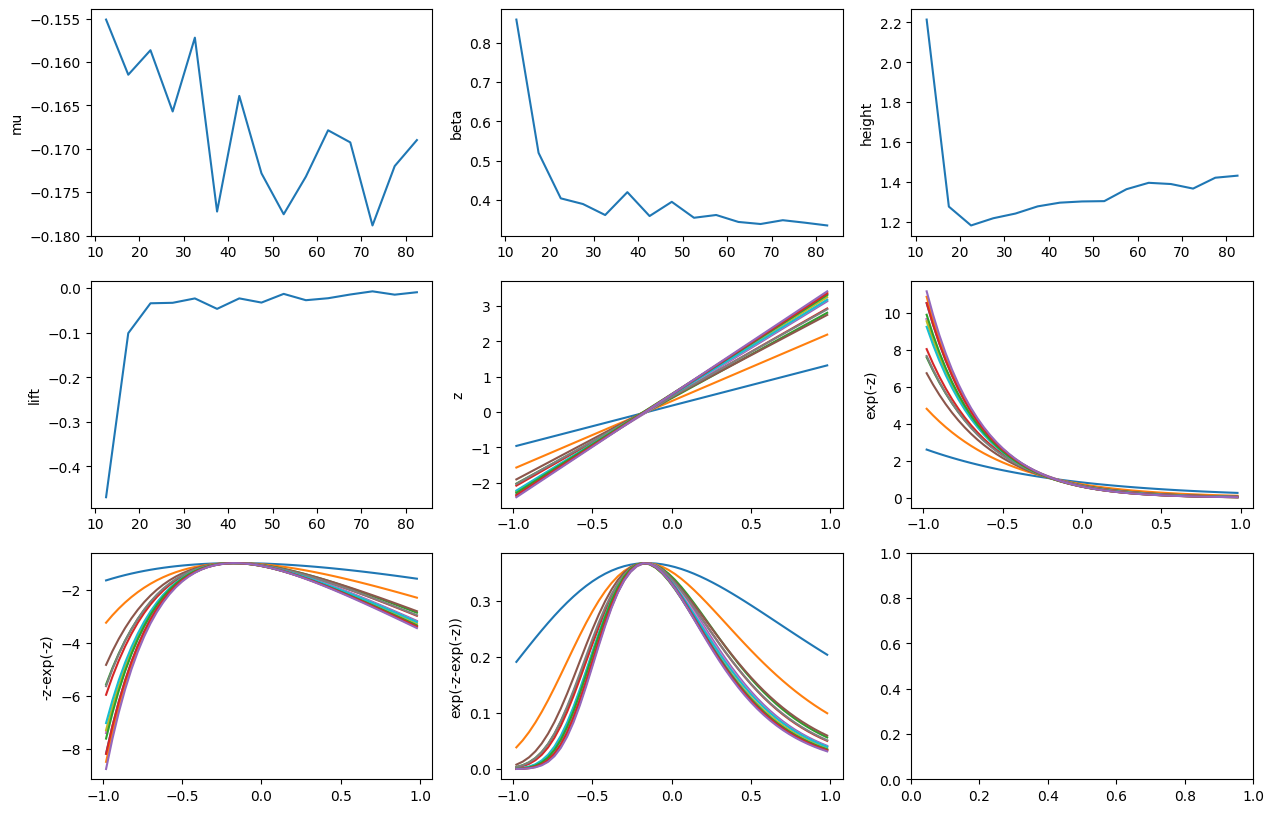

In [9]:

bin_weights = acc.total_events[1:-1]

from pointcloud.models.fish_parametrise import binned_mean_energy, fit_mean_energy_vs_distance, fit_mean_energy
binned_mean_e = binned_mean_energy(acc)
binned_weighted_mean_e = binned_mean_e * bin_weights
found_mu, found_beta, found_height, found_lift = fit_mean_energy_vs_distance(binned_mean_e, param.distance_centers)
found_mean_e = np.empty_like(binned_mean_e)
from pointcloud.utils.maths import gumbel
for i, inc in enumerate(incidents):
    found_here = gumbel(torch.tensor(distances), found_mu[i],
                        found_beta[i], found_height[i], found_lift[i])
    found_mean_e[i] = found_here
found_weighted_mean_e = found_mean_e * bin_weights 
    

fig, ax_arr = plt.subplots(3, 3, figsize=(15, 10))
ax_arr = ax_arr.flatten()
names = ["mu", "beta", "height", "lift"]
y_vals = [found_mu, found_beta, found_height, found_lift]
for name, ax, ys in zip(names, ax_arr, y_vals):
    ax.plot(param.incident_centers, ys)
    ax.set_ylabel(name)

incident_colours = plt.cm.rainbow_r(np.linspace(0, 1, len(param.incident_centers)))
with np.errstate(over='raise'):
    z = (param.distance_centers[:, np.newaxis] - found_mu)/found_beta
    exp_mz = np.exp(-z)
    mz_exp_mz = -z - exp_mz
    gum = np.exp(mz_exp_mz)
    y_vals = [z, exp_mz, mz_exp_mz, gum]
    names = ["z", "exp(-z)", "-z-exp(-z)", "exp(-z-exp(-z))"]
    for name, ax, ys in zip(names, ax_arr[4:], y_vals):
        for c, col in enumerate(incident_colours):
            ax.plot(param.distance_centers, ys[:, c])
        ax.set_ylabel(name)
        
# paramd bins
from pointcloud.utils.maths import gumbel
mus = np.polyval(param.me_mu, incidents)[:, np.newaxis]
betas = np.polyval(param.me_beta, incidents)[:, np.newaxis]
heights = np.polyval(param.me_height, incidents)[:, np.newaxis]
lifts = np.polyval(param.me_lift, incidents)[:, np.newaxis]
paramd_energy = gumbel(torch.tensor(distances), torch.tensor(mus),
                       torch.tensor(betas), torch.tensor(heights), 
                       torch.tensor(lifts))
paramd_weighted_energy = paramd_energy*bin_weights

cv_energy = np.polyval(param.cv_energy, distances)
paramd_std_energy = paramd_energy*cv_energy
paramd_weighted_std_energy = paramd_weighted_energy*cv_energy


# stats bins
from torch.distributions.log_normal import LogNormal
dist = LogNormal(stats["energy_lognorm_loc"], stats["energy_lognorm_scale"])
stats_weighted_energy = dist.mean*bin_weights
stats_weighted_std_energy = dist.stddev*bin_weights

# sampled bins
sampled_energy = components['mean_energy'].numpy()
sampled_energy = sampled_energy.reshape((-1, n_samples, sampled_energy.shape[-1]))
sampled_energy = np.swapaxes(sampled_energy, 0, 1)
sampled_mean_energy = np.nanmean(sampled_energy, axis=0)
sampled_std_energy = np.nanstd(sampled_energy, axis=0)

print(gum.max())

Text(0, 0.5, 'LogNormal scale')

/home/dayhallh/Documents.local/miniconda3/envs/calocpu/lib/python3.11/site-packages/matplotlib/axes/_base.py:2957: RuntimeWarning: overflow encountered in scalar subtract
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


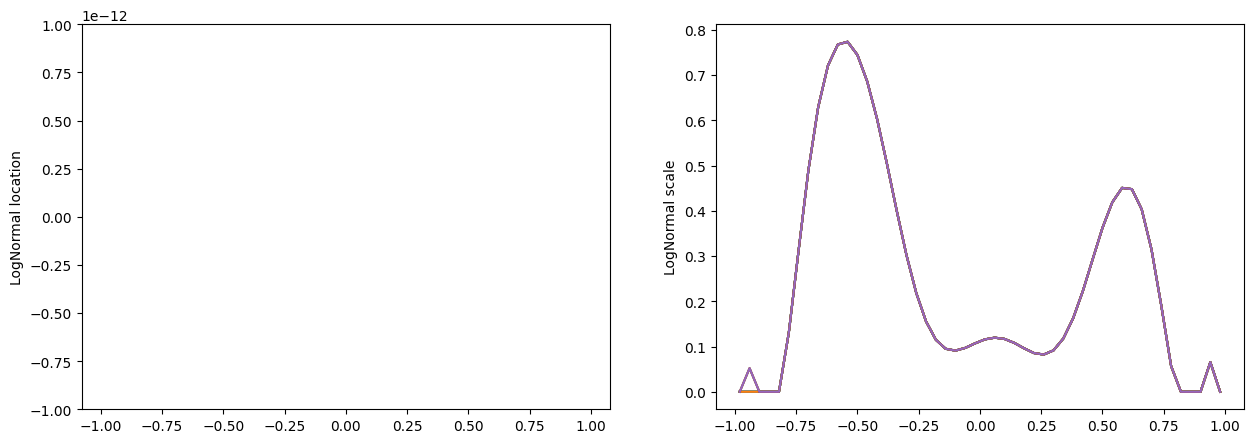

In [10]:
fig, (ax_loc, ax_scale) = plt.subplots(1, 2, figsize=(15, 5))
for c, col in enumerate(incident_colours):
    ax_loc.plot(param.distance_centers, stats["energy_lognorm_loc"][c])
    ax_scale.plot(param.distance_centers, stats["energy_lognorm_scale"][c])
ax_loc.set_ylabel("LogNormal location")
ax_scale.set_ylabel("LogNormal scale")

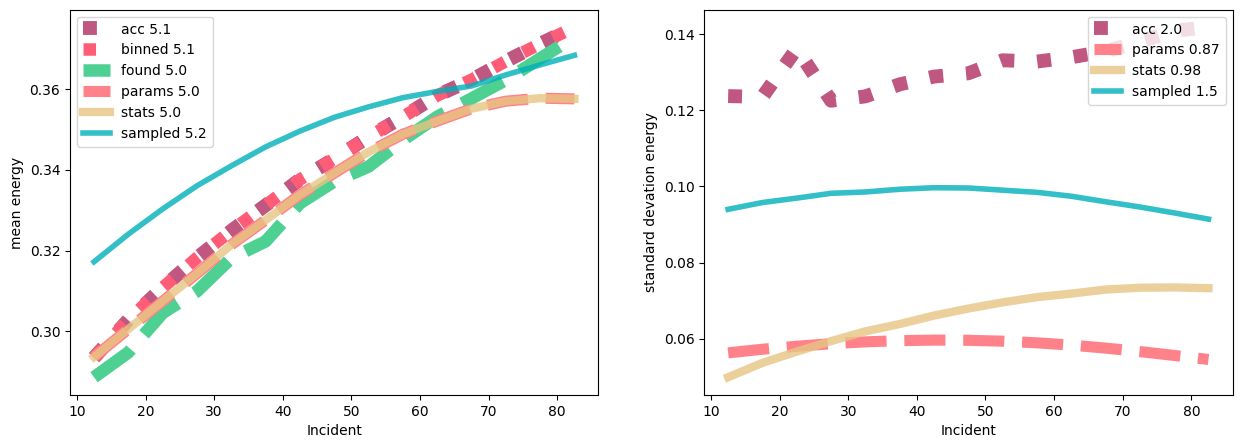

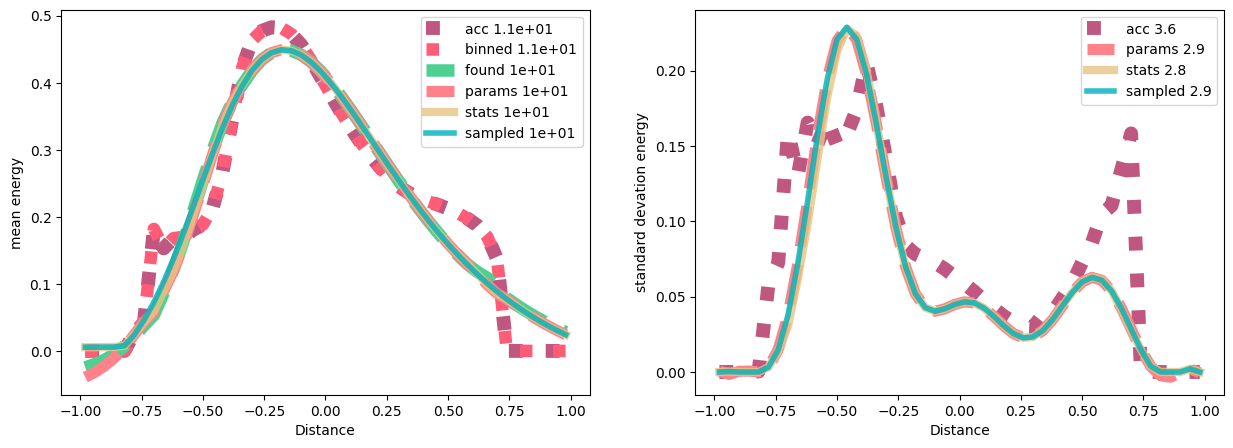

In [11]:
for dim_number in range(2):
    fig, (ax_m, ax_s) = plt.subplots(1, 2, figsize=(15, 5))
    
    if dim_number == 0:
        x_label = "Incident"
        x_positions = incidents
        n_bins = 25  # this is odd....
        n_bins = 30
        # think it should be the number of layers, 30, but it isn't
        sum_over = 1
    else:
        x_label = "Distance"
        x_positions = distances
        n_bins = incidents.shape[0]
        sum_over = 0
    # accumulator
    n_events_per_x = np.nansum(acc.total_events[1:-1], axis=sum_over)
    energy_hist = acc.evt_mean_E_hist[1:-1]
    mean_energy_acc = np.nansum(energy_hist, axis=(sum_over))/n_events_per_x
    energy_hist_sq = acc.evt_mean_E_sq_hist[1:-1]
    mean_energy_sq = np.nansum(energy_hist_sq, axis=(sum_over))/n_events_per_x
    std_energy_acc = np.sqrt(mean_energy_sq - mean_energy_acc**2)

    acc_kws["label"] = f"acc {np.nansum(mean_energy_acc):.2}"
    ax_m.plot(x_positions, mean_energy_acc, **acc_kws)
    acc_kws["label"] = f"acc {np.nansum(std_energy_acc):.2}"
    ax_s.plot(x_positions, std_energy_acc, **acc_kws)
    acc_kws["label"] = "acc"

    # binnd
    mean_energy_binned = np.nansum(binned_weighted_mean_e, axis=sum_over)/np.nansum(bin_weights, axis=sum_over)
    #mean_energy_binned = np.nansum(binned_mean_e, axis=sum_over)
    binned_kws["label"] = f"binned {np.nansum(mean_energy_binned):.2}"
    ax_m.plot(x_positions, mean_energy_binned, **binned_kws)
    binned_kws["label"] = "binned"
    
    # found
    mean_energy_found = np.nansum(found_weighted_mean_e, axis=sum_over)/np.nansum(bin_weights, axis=sum_over)
    found_kws["label"] = f"found {np.nansum(mean_energy_found):.2}"
    ax_m.plot(x_positions, mean_energy_found, **found_kws)
    found_kws["label"] = "found"
    
    # paramd
    mean_energy_param = np.nansum(paramd_weighted_energy, axis=sum_over)/np.nansum(bin_weights, axis=sum_over)
    std_energy_param = np.nansum(paramd_weighted_std_energy, axis=sum_over)/np.nansum(bin_weights, axis=sum_over)
    std_energy_param = np.nanmean(paramd_std_energy, axis=sum_over)
    param_kws["label"] = f"params {np.nansum(mean_energy_param):.2}"
    ax_m.plot(x_positions, mean_energy_param, **param_kws)
    param_kws["label"] = f"params {np.nansum(std_energy_param):.2}"
    ax_s.plot(x_positions, std_energy_param, **param_kws)
    param_kws["label"] = "params"
    
    # statsd
    mean_energy_stats = np.nansum(stats_weighted_energy, axis=sum_over)/np.nansum(bin_weights, axis=sum_over)
    std_energy_stats = np.nansum(stats_weighted_std_energy, axis=sum_over)/np.nansum(bin_weights, axis=sum_over)
    stats_kws["label"] = f"stats {np.nansum(mean_energy_stats):.2}"
    ax_m.plot(x_positions, mean_energy_stats, **stats_kws)
    stats_kws["label"] = f"stats {np.nansum(std_energy_stats):.2}"
    ax_s.plot(x_positions, std_energy_stats, **stats_kws)
    stats_kws["label"] = "stats"
    
    # sampled_stats
    mean_energy_sampled = np.nansum(sampled_mean_energy, axis=sum_over)/n_bins
    std_energy_sampled = np.nansum(sampled_std_energy, axis=sum_over)/n_bins
    
    sampled_kws["label"] = f"sampled {np.sum(mean_energy_sampled):.2}"
    ax_m.plot(x_positions, mean_energy_sampled, **sampled_kws)
    sampled_kws["label"] = f"sampled {np.sum(std_energy_sampled):.2}"
    ax_s.plot(x_positions, std_energy_sampled, **sampled_kws)
    sampled_kws["label"] = "sampled"
    
    ax_s.legend()
    ax_m.legend()
    ax_m.set_xlabel(x_label)
    ax_s.set_xlabel(x_label)
    ax_m.set_ylabel("mean energy")
    ax_s.set_ylabel("standard devation energy")
    

## Standard devation of energy within a layer

Energy of the points in a layer varies. This is caputured in the standard devation for the energy in each layer

/home/dayhallh/training/point-cloud-diffusion/scripts/plotting/pointcloud/models/fish_parametrise.py:529: RuntimeWarning: invalid value encountered in sqrt
  std_e_within = np.sqrt(pnt_mean_E_sq - mean_pnt_E_sq)
/tmp/ipykernel_22593/1242231081.py:45: RuntimeWarning: invalid value encountered in divide
  energy_var = np.sqrt(energy_sq_hist/n_pts_per_x - (energy_hist/n_pts_per_x)**2)


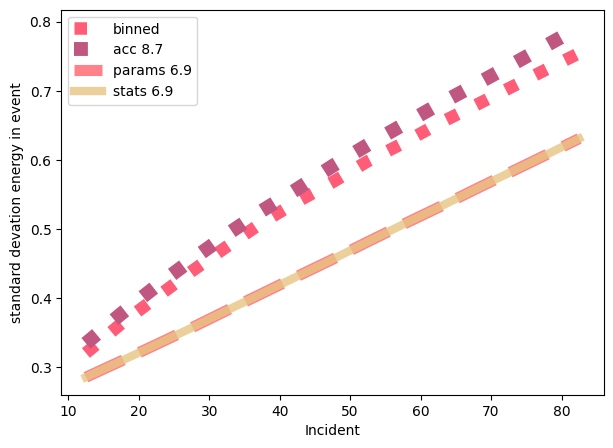

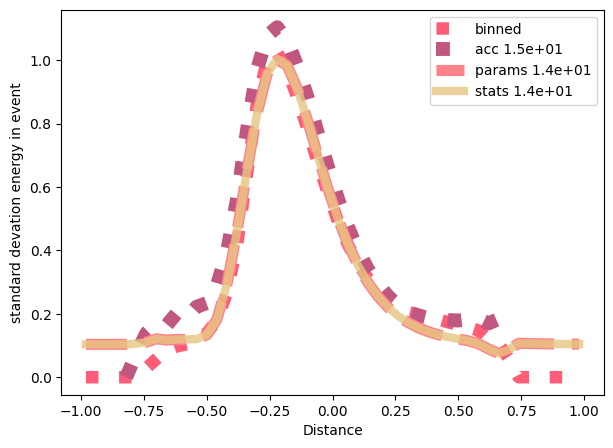

In [12]:

bin_weights = acc.total_events[1:-1]

# binned
from pointcloud.models.fish_parametrise import binned_stdEWithin_vs_incident, rescaled_stdEWithin_vs_distance, fit_stdEWithin_vs_distance
incident_binned_sewe = binned_stdEWithin_vs_incident(acc)
distance_rescaled_binned_sewe = rescaled_stdEWithin_vs_distance(acc, param.sewe_vs_incident, incidents)
distance_binned_sewe = np.nansum(distance_rescaled_binned_sewe * bin_weights *incident_binned_sewe[:, np.newaxis], axis=0)/np.nansum(bin_weights, axis=0)

# paramd bins
paramd_vs_dist_sewe = gumbel(torch.tensor(distances), param.sewe_vs_dist_mu,
                             param.sewe_vs_dist_beta, param.sewe_vs_dist_height,
                             param.sewe_vs_dist_lift)
paramd_vs_incident_sewe = np.polyval(param.sewe_vs_incident, incidents)[:, np.newaxis]
paramd_sewe = paramd_vs_dist_sewe * paramd_vs_incident_sewe
paramd_weighted_sewe = paramd_sewe*bin_weights

# stats bins
from torch.distributions.log_normal import LogNormal
dist = LogNormal(stats["stdEWithin_lognorm_loc"], stats["stdEWithin_lognorm_scale"])
stats_weighted_sewe = dist.stddev*bin_weights

for dim_number in range(2):
    fig, ax_m = plt.subplots(1, 1, figsize=(7, 5))
    
    if dim_number == 0:
        x_label = "Incident"
        x_positions = incidents
        n_bins = 25  # this is odd....
        # think it should be the number of layers, 30, but it isn't
        n_bins = 30
        sum_over = 1
        binning = incident_binned_sewe
    else:
        x_label = "Distance"
        x_positions = distances
        n_bins = incidents.shape[0]
        sum_over = 0
        binning = distance_binned_sewe
    # binned
    ax_m.plot(x_positions, binning, **binned_kws)
    # accumulator
    n_pts_per_x = np.nansum(acc.counts_hist[1:-1], axis=(sum_over, 2, 3))
    energy_hist = np.nansum(acc.energy_hist[1:-1], axis=(sum_over, 2, 3))
    energy_sq_hist = np.nansum(acc.energy_sq_hist[1:-1], axis=(sum_over, 2, 3))
    energy_var = np.sqrt(energy_sq_hist/n_pts_per_x - (energy_hist/n_pts_per_x)**2)

    acc_kws["label"] = f"acc {np.nansum(energy_var):.2}"
    ax_m.plot(x_positions, energy_var, **acc_kws)
    acc_kws["label"] = "acc"

    # paramd
    energy_var_param = np.nansum(paramd_weighted_sewe, axis=sum_over)/np.nansum(bin_weights, axis=sum_over)
    param_kws["label"] = f"params {np.nansum(energy_var_param):.2}"
    ax_m.plot(x_positions, energy_var_param, **param_kws)
    param_kws["label"] = "params"
    
    # statsd
    energy_var_stats = np.nansum(stats_weighted_sewe, axis=sum_over)/np.nansum(bin_weights, axis=sum_over)
    stats_kws["label"] = f"stats {np.nansum(energy_var_stats):.2}"
    ax_m.plot(x_positions, energy_var_stats, **stats_kws)
    stats_kws["label"] = "stats"
    
    # sampled_stats is only axial, so not this one
    
    ax_m.legend()
    ax_m.set_xlabel(x_label)
    ax_m.set_ylabel("standard devation energy in event")
    
